In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from sklearn.model_selection import train_test_split

### Data Processing

In [2]:
df = pd.read_pickle('../pickle/df.pkl')

In [3]:
df_sampled = df.sample(200,random_state=47)

In [4]:
df_features = df_sampled.iloc[:,:-1].copy()
df_target = df_sampled.iloc[:,-1].copy()

In [5]:
scaler = StandardScaler()
df_features = scaler.fit_transform(df_features)

In [6]:
df_train_features, df_test_features,df_train_target, df_test_target =  train_test_split(df_features,df_target,stratify=df_target,random_state=47, test_size=0.5)

In [7]:
df_train_target = df_train_target.to_numpy()
df_test_target = df_test_target.to_numpy()

In [8]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
n_cat = 11 

### Ancestral Sampling 

In [73]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [102]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [ 0.03384073  0.42315366  1.59006247  0.61605788  0.51067624 -1.07942578
  0.95632943 -0.26202731  0.74619885  1.1786503  -0.96734413 -0.13801228
 -1.7474055  -0.99338937]


In [103]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))
label_array

array([ 0.,  7.,  4.,  4.,  4.,  8.,  5.,  4.,  1., 10.,  6.,  8.,  3.,
        4.,  9.,  1.,  1.,  7.,  6.,  4.,  5.,  4.,  2.,  8.,  1.,  1.,
        8.,  2., 10.,  7.,  5.,  3.,  4.,  3.,  4.,  8.,  4.,  6.,  6.,
        4.,  7.,  4.,  4., 10.,  2.,  0.,  1.,  1.,  1.,  5.,  7.,  9.,
        1.,  7., 10.,  0.,  2.,  3.,  1.,  4.,  7.,  5.,  1.,  4.,  1.,
        1.,  7.,  8.,  8.,  7.,  8.,  4.,  4.,  3.,  4., 10.,  6.,  4.,
        0.,  4.,  4.,  1.,  8.,  0., 10.,  4., 10.,  1.,  0.,  6.,  1.,
       10.,  1.,  4.,  1.,  3.,  1.,  1.,  4.,  1.])

In [104]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({0.0: 6,
         7.0: 9,
         4.0: 24,
         8.0: 9,
         5.0: 5,
         1.0: 21,
         10.0: 8,
         6.0: 6,
         3.0: 6,
         9.0: 2,
         2.0: 4})

In [106]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.06


### Model implementation with Pyro

In [107]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [108]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Model training 

In [109]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 1657.5
[1000] ELBO: 861.2
[2000] ELBO: 593.4
[3000] ELBO: 479.9
[4000] ELBO: 435.3
[5000] ELBO: 406.4
[6000] ELBO: 397.3
[7000] ELBO: 388.5
[8000] ELBO: 380.3
[9000] ELBO: 385.9
[10000] ELBO: 360.9
[11000] ELBO: 366.1
[12000] ELBO: 346.1
[13000] ELBO: 361.2
[14000] ELBO: 355.8
[15000] ELBO: 361.0
[16000] ELBO: 350.9
[17000] ELBO: 354.3
[18000] ELBO: 353.4
[19000] ELBO: 360.3


In [110]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train)

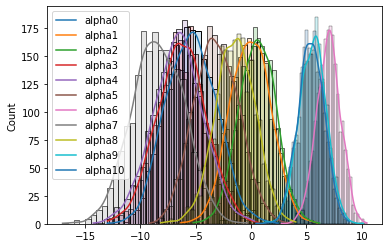

In [111]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

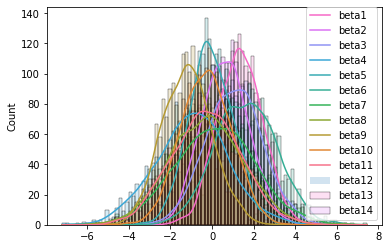

In [112]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [113]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

### Inference and computation of accuracy on the train dataset 

In [114]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [115]:
y_train_pred = y_train_pred[:,0]

In [116]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.65


### Inference and computation of accuracy on the test dataset 

In [117]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [118]:
y_test_pred = y_test_pred[:,0]

In [119]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.31



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 

TODO

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Consider different distributions for priors
* Train model on more data - currently 100 
* Extend it with FFNN 
* Feature engineer name and album name and retrain logistic regression model using these attributes